## **MANDLEBROT SET GPU RUNTIME**

/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:69: NumbaDeprecationWarning: Deprecated keyword argument `argtypes`. Signatures should be passed as the first positional argument.
  warn(msg, category=NumbaDeprecationWarning)
/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:69: NumbaDeprecationWarning: Deprecated keyword argument `argtypes`. Signatures should be passed as the first positional argument.
  warn(msg, category=NumbaDeprecationWarning)


Mandelbrot created on GPU in 0.022354 s


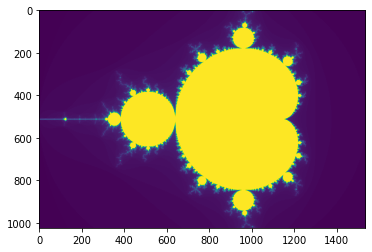

In [ ]:
from numba import cuda
from numba import *
import numpy as np
from numba import jit
from pylab import imshow, show
from timeit import default_timer as timer

@jit
def mandel(x, y, max_iters):

  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters



mandel_gpu = cuda.jit(restype=uint32, argtypes=[f8, f8, uint32], device=True)(mandel)

@cuda.jit(argtypes=[f8, f8, f8, f8, uint8[:,:], uint32])
def mandel_kernel(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height

  startX, startY = cuda.grid(2)
  gridX = cuda.gridDim.x * cuda.blockDim.x;
  gridY = cuda.gridDim.y * cuda.blockDim.y;

  for x in range(startX, width, gridX):
    real = min_x + x * pixel_size_x
    for y in range(startY, height, gridY):
      imag = min_y + y * pixel_size_y 
      image[y, x] = mandel_gpu(real, imag, iters)
gimage = np.zeros((1024, 1536), dtype = np.uint8)
blockdim = (32, 8)
griddim = (32,16)

start = timer()
d_image = cuda.to_device(gimage)
mandel_kernel[griddim, blockdim](-2.0, 1.0, -1.0, 1.0, d_image, 140) 
d_image.to_host()
dt = timer() - start

print("Mandelbrot created on GPU in %f s" % dt)

imshow(gimage)
show()
